In [1]:
import os
from os.path import join
import sys
import numpy as np 
import pandas as pd
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Eye Bias Analysis
Test whether there is a bias toward either the left or right eye. Test whether eye bias can be predicted by gender, handedness, or image category

#### **Note:** "left" is relative to the viewer (i.e. the 'right' anatomically)

In [3]:
# load the combined cursorTracking data for all subjs
df = pd.read_table('../../data/groupData/allSubjsRaw.tsv', sep='\t')

In [4]:
df.shape

(608261, 7)

In [5]:
df.head()

,ts,x,y,subjID,stim,trialNum,AOI
0,98,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
1,123,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
2,154,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
3,172,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none
4,188,461.5,131.0,27235,_images707/bw_hmn/bw_hmn_wm02.jpg,1,none


### Select the stimuli to include in analysis
For the eye-bias analysis, use the bw_hmn and hmn stimuli only

In [6]:
# function to label the image categories
def labelStimCategory(row):
    if ("_images707/bw_hmn/" in row['stim']) |  ("_images707/hmn/" in row['stim']):
        label = 'human'
    elif "_images707/animal/" in row['stim']:
        label = 'animal'
    elif "_images707/FLO/" in row['stim']:
        label = 'FLO'
    elif "_images707/art/Port_" in row['stim']:
        label = 'portrait'
    elif "_images707/art/mutu_" in row['stim']:
        label = 'Mutu'
    else:
        label = "Na"
    
    return label

In [7]:
# add image category label to dataframe
df['stimCategory'] = df.apply(labelStimCategory, axis=1)

In [8]:
# make sure this worked
df['stimCategory'].unique()

array(['human', 'Na', 'animal', 'FLO', 'portrait', 'Mutu'], dtype=object)

In [9]:
# remove 'Na' rows
df = df[df['stimCategory'] != 'Na']
df.shape

(229976, 8)

In [10]:
# write this out as a txt file so you don't have to load the really big one again
df.to_csv('eyeBias_allSubjsRaw.tsv', sep='\t', index=False)

---
### Create within-trial time spent on each AOI
For each trial for each subject, calculate the mean time per AOI. The mean time for each AOI is calculated by taking the mean frame interval across that trial (i.e. the mean interval between successive timestamps) and multiplying it by the number of frames labeled for each AOI.

e.g. On a given trial:

 * 298 frames
 * 16.8 mean frame interval
 * 67 frames labeled 'leftEye'

In [11]:
# create a table showing the mean frame interval on each trial
trialFrameTimes = df.groupby(['subjID', 'trialNum'], as_index=False).ts.agg(lambda x: x.diff().mean())
trialFrameTimes.head()

,subjID,trialNum,ts
0,741,2,20.639004
1,741,3,25.968586
2,741,4,27.359116
3,741,6,26.484043
4,741,8,26.607527


In [12]:
# create a table showing the number of datapoints labeled for each AOI 
ptsPerAOI = df.groupby(['subjID', 'trialNum', 'AOI'], as_index=False).ts.agg(lambda x: len(x))
ptsPerAOI.head()

,subjID,trialNum,AOI,ts
0,741,2,leftEye,14
1,741,2,mouth,44
2,741,2,none,144
3,741,2,nose,25
4,741,2,rightEye,15


In [16]:
# function to calculate time per AOI
def calculateTimePerAOI(row):
    # get the mean frame interval for this trial
    meanFrameInterval = trialFrameTimes[(trialFrameTimes.subjID == row['subjID']) & 
                                (trialFrameTimes.trialNum == row['trialNum'])].ts.iloc[0]
    
    # multiply the mean frame interval by the number of frames
    AOI_time = meanFrameInterval * row['ts']
    return AOI_time


In [17]:
ptsPerAOI['AOI_time'] = ptsPerAOI.apply(calculateTimePerAOI, axis=1)

In [19]:
ptsPerAOI.head()

,subjID,trialNum,AOI,ts,AOI_time
0,741,2,leftEye,14,288.946058
1,741,2,mouth,44,908.116183
2,741,2,none,144,2972.016598
3,741,2,nose,25,515.975104
4,741,2,rightEye,15,309.585062


In [22]:
# basic cleanup and reformatting
df_byAOIs = ptsPerAOI.copy()
df_byAOIs = df_byAOIs.rename(columns={'ts':'numFrames'}) 
df_byAOIs.head()

,subjID,trialNum,AOI,numFrames,AOI_time
0,741,2,leftEye,14,288.946058
1,741,2,mouth,44,908.116183
2,741,2,none,144,2972.016598
3,741,2,nose,25,515.975104
4,741,2,rightEye,15,309.585062


In [25]:
# ok, now relabel the rows with stim names and stim categories
def labelStim(row):
    thisStim = df[(df.subjID == row['subjID']) & (df.trialNum == row['trialNum'])].iloc[0].stim
    return thisStim

def labelCategory(row):
    thisCategory = df[(df.subjID == row['subjID']) & (df.trialNum == row['trialNum'])].iloc[0].stimCategory
    return thisCategory
    

In [26]:
df_byAOIs['stim'] = df_byAOIs.apply(labelStim, axis=1)
df_byAOIs['stimCategory'] = df_byAOIs.apply(labelCategory, axis=1)

df_byAOIs.head()

,subjID,trialNum,AOI,numFrames,AOI_time,stim,stimCategory
0,741,2,leftEye,14,288.946058,_images707/hmn/hmn_wm04.jpg,human
1,741,2,mouth,44,908.116183,_images707/hmn/hmn_wm04.jpg,human
2,741,2,none,144,2972.016598,_images707/hmn/hmn_wm04.jpg,human
3,741,2,nose,25,515.975104,_images707/hmn/hmn_wm04.jpg,human
4,741,2,rightEye,15,309.585062,_images707/hmn/hmn_wm04.jpg,human


### Add gender and handedness to the dataframe

In [27]:
dem_data = pd.read_table('../../data/groupData/AbsFace Demographics_May 11, 2017_19.30.csv', sep=',')

Q1 - WBL ID;
Q2 - Age;
Q3 - Gender;
Q15 - Handedness

In [28]:
dem_data = dem_data[['Q1', 'Q2', 'Q3', 'Q15']]

In [31]:
def labelGender(row):
    "find the gender based on subjID"
    subjID = str(row['subjID']) # get the subjID
    
    # grab the row with the subject's demographic data
    subj_dem = dem_data[dem_data.Q1.str.find(subjID) == 0]
    
    return subj_dem.Q3.values[0]


def labelHandedness(row):
    "find the handedness based on subjID"
    subjID = str(row['subjID']) # get the subjID
    
    # grab the row with the subject's demographic data
    subj_dem = dem_data[dem_data.Q1.str.find(subjID) == 0]
    
    return subj_dem.Q15.values[0]

In [32]:
df_byAOIs['gender'] = df_byAOIs.apply(labelGender, axis=1)
df_byAOIs['handedness'] = df_byAOIs.apply(labelHandedness, axis=1)

df_byAOIs.head()

,subjID,trialNum,AOI,numFrames,AOI_time,stim,stimCategory,gender,handedness
0,741,2,leftEye,14,288.946058,_images707/hmn/hmn_wm04.jpg,human,Male,Right-handed
1,741,2,mouth,44,908.116183,_images707/hmn/hmn_wm04.jpg,human,Male,Right-handed
2,741,2,none,144,2972.016598,_images707/hmn/hmn_wm04.jpg,human,Male,Right-handed
3,741,2,nose,25,515.975104,_images707/hmn/hmn_wm04.jpg,human,Male,Right-handed
4,741,2,rightEye,15,309.585062,_images707/hmn/hmn_wm04.jpg,human,Male,Right-handed


---
### Calculate the eye-bias score for each trial

In [69]:
# create a dataframe with just the rows corresponding to eye AOIs
df_eyesOnly = df_byAOIs[(df_byAOIs.AOI == 'leftEye') | (df_byAOIs.AOI == 'rightEye')]

# go through each trial, and calculate the eyeBias score
for i, (name, group) in enumerate(df_eyesOnly.groupby(['subjID', 'trialNum'])):
    # check to make sure the values exist for each eye
    if 'rightEye' not in group['AOI'].values:
        rightEyeTime = 0
    else:
        rightEyeTime = group[group['AOI'] == 'rightEye'].AOI_time.item()
        
    if 'leftEye' not in group['AOI'].values:
        leftEyeTime = 0
    else:
        leftEyeTime = group[group['AOI'] == 'leftEye'].AOI_time.item()
    
    # calculate eyeBias as right eye minus left eye
    eyeBias = rightEyeTime - leftEyeTime
    
    # get other values for this row
    subj = group.subjID.iloc[0]
    trialNum = group.trialNum.iloc[0]
    stim = group.stim.iloc[0]
    stimCategory = group.stimCategory.iloc[0]
    gender = group.gender.iloc[0]
    handedness = group.handedness.iloc[0]
    
    # construct into a series object
    thisRow = {'subjID': subj,
                        'trialNum': trialNum,
                        'stim':stim,
                        'stimCategory': stimCategory,
                        'gender':gender,
                        'handedness':handedness,
                        'eyeBias':eyeBias}
    if i == 0:
        df_eyeBias = pd.DataFrame(thisRow, index=[0])
    else:
        df_eyeBias = df_eyeBias.append(thisRow, ignore_index=True)

In [70]:
df_eyeBias.head()

,eyeBias,gender,handedness,stim,stimCategory,subjID,trialNum
0,20.639004,Male,Right-handed,_images707/hmn/hmn_wm04.jpg,human,741,2
1,519.371728,Male,Right-handed,_images707/art/mutu_2.jpg,Mutu,741,3
2,264.840426,Male,Right-handed,_images707/animal/cat03.jpg,animal,741,6
3,-2953.435484,Male,Right-handed,_images707/FLO/flo07.jpg,FLO,741,8
4,-105.063830,Male,Right-handed,_images707/hmn/hmn_wf04.jpg,human,741,14


In [48]:
df2.AOI.values

array(['none', 'none', 'none', 'none', 'none', 'none'], dtype=object)

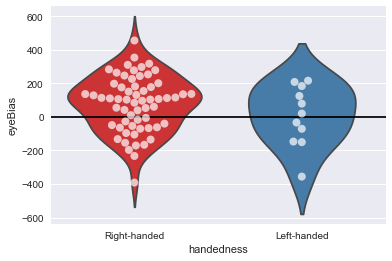

In [30]:
# plot
sns.violinplot(x=allSubjs.handedness, y=allSubjs.eyeBias, inner=None, palette='Set1')
sns.swarmplot(x=allSubjs.handedness, y=allSubjs.eyeBias, color='w', size=8, alpha=.7)
plt.axhline(y=0, color='black')

In [31]:
# stats
R = allSubjs.eyeBias[allSubjs.handedness=='Right-handed']
L = allSubjs.eyeBias[allSubjs.handedness=='Left-handed']

stats.ttest_ind(R, L, equal_var=True)

Ttest_indResult(statistic=1.3129549201948119, pvalue=0.19348619142777496)

In [32]:
# count by condition
allSubjs.groupby('handedness').count()

,eyeBias,gender
handedness,,
Left-handed,11,11
Right-handed,61,61


In [9]:
# loop over all unique subjects
subjMeans = []
for s in np.unique(df2.subjID):
    # grab this subjects data
    subj_df = df2.loc[df2.subjID == s]
    
    # loop through unique trials
    trial_eyeBias = []
    for i,t in enumerate(np.unique(subj_df.trialNum)):
        # grab this trial's data
        trial_df = subj_df[subj_df.trialNum == t]
        
        # calculate mean time/frame
        meanFrameInterval = trial_df.ts.diff().mean()
        
        # get number of frames for each AOI
        AOI_counts = trial_df.AOI.value_counts()
        
        # multiple frame counts by mean frame interval to get time spent in the AOI
        AOI_time = AOI_counts * meanFrameInterval
        
        # make sure left and right eye are represented
        if 'leftEye' not in AOI_time:
            AOI_time.leftEye = 0
        if 'rightEye' not in AOI_time:
            AOI_time.rightEye = 0
        
        # calculate bias score
        eyeBias = AOI_time.leftEye - AOI_time.rightEye
        
        # append to the list of bias for all trials
        trial_eyeBias.append(eyeBias)

    # calculate the mean across trials
    subj_eyeBias = np.mean(trial_eyeBias)
    
    # create a series out of it
    thisSubj = pd.Series({'eyeBias': subj_eyeBias}, name=s)
    subjMeans.append(thisSubj)
    
allSubjs = pd.concat(subjMeans, axis=1).T
    

In [10]:
allSubjs.head()

,eyeBias
741,310.135744
1164,197.855359
20649,-70.862152
27235,-391.586942
27537,278.392258


In [11]:
np.mean(allSubjs)

eyeBias    68.292473
dtype: float64

#### is there an overall bias toward the left eye in this dataset?

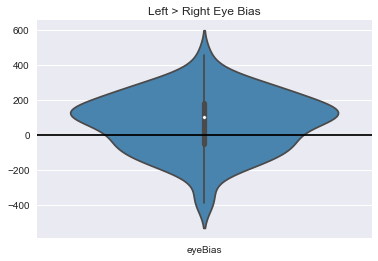

In [12]:
# plot
sns.violinplot(data=allSubjs, palette='Blues_d')
sns.plt.title('Left > Right Eye Bias')
plt.axhline(y=0, color='k')


In [13]:
import scipy.stats as stats

In [14]:
# run the t-test

stats.ttest_1samp(allSubjs.eyeBias, 0)

Ttest_1sampResult(statistic=3.5007809337445597, pvalue=0.00080044588565999152)